# Survival Analysis and BigQuery

This notebook demonstrates how to use BigQuery to gather data to use in Survival analysis. We will be using mutation of the BRCA gene to predict the survival between mutation of BRCA and normal.

## Further Reading on Survival Analysis

Rich, Jason T et al. “A practical guide to understanding Kaplan-Meier curves.” Otolaryngology--head and neck surgery : official journal of American Academy of Otolaryngology-Head and Neck Surgery vol. 143,3 (2010): 331-6. [doi:10.1016/j.otohns.2010.05.007](doi:10.1016/j.otohns.2010.05.007)

## Load Libraries and Authorize with BigQuery

In [2]:
#Load Libraries and authorize with BigQuery
library(bigrquery)
library(tidyverse)
library(survival)
library(ggfortify)
bigrquery::bq_auth(path = "~/key-file")
project <- 'isb-cgc-bq'

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Gather Data

## Technical terms

| Name | Description |
| :--- | :--- |
| isb-cgc-bq | Google project name of ISB-CGC |
| TCGA.somatic_mutation_hg38_gdc_current | BigQuery dataset and table containing TCGA somatic mutation data |
| TCGA.clinical_gdc_current | BigQuery dataset and table containing TCGA clinical data |
| project_short_name | The column name with the project name abbreviation |
| Hugo_Symbol| The HUGO symbol for the gene |
| demo__vital_status | The column with the survival state of the patient |
| demo__days_to_death | The column with the number of days between the date used for index and the date from the patients death |
| diag__days_to_last_follow_up | The column with the days between the initial diagnosis and the last follow with the patient |

## Retrieve Patient BRCA Mutation Status from BigQuery
The first component of our data set is the status of the ERBB2 mutation for the patient. 

Table: *isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current*

In [28]:
cohort_query <- "WITH t AS (
            SELECT case_id, Hugo_Symbol
            FROM `isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current`
            WHERE
              project_short_name = 'TCGA-BRCA')
            SELECT DISTINCT case_id,
              CASE
                WHEN Hugo_Symbol = 'ERBB2' THEN 'ERBB2'
                ELSE 'none'
              END
              AS gene_status
            FROM t
            ORDER BY gene_status"
# Run the query
cohort <- bq_project_query(project, cohort_query, quiet = TRUE) 
# Create a dataframe with the results from the query
cohort <- bq_table_download(cohort, quiet = TRUE)
# Show the dataframe
summary(cohort)

   case_id          gene_status       
 Length:1020        Length:1020       
 Class :character   Class :character  
 Mode  :character   Mode  :character  

## Retrieve Clinical Data From BigQuery

The other important component of our data set is the patient's vital status and either days to death or days to last follow up.

Table: *isb-cgc-bq.TCGA.clinical_gdc_current*

In [75]:
survival_query <- str_c("
  SELECT 
    case_id,
    submitter_id,
    demo__vital_status,
    demo__days_to_death,
    diag__days_to_last_follow_up
  FROM `isb-cgc-bq.TCGA.clinical_gdc_current`
  WHERE
    case_id IN ('", str_c(cohort$case_id, collapse = "', '"),"') AND
    demo__vital_status IS NOT NULL")

survival_request <- bq_project_query(project, survival_query)
survival_data <- bq_table_download(survival_request)
survival <- left_join(survival_data, cohort, key = "case_id")
head(survival)

Joining, by = "case_id"



case_id,submitter_id,demo__vital_status,demo__days_to_death,diag__days_to_last_follow_up,gene_status
<chr>,<chr>,<chr>,<int>,<dbl>,<chr>
e98b69bc-766a-485f-b5e8-9166b8d457b3,TCGA-A8-A099,Alive,NA,304,none
b205bba0-1870-4458-9088-8817e20389fe,TCGA-A8-A09A,Alive,NA,304,none
80f3f48a-cc21-415c-b181-c77e7ba1c563,TCGA-A8-A09C,Alive,NA,31,none
6e6408d6-6c48-4dfc-9f1c-28b7386e87b4,TCGA-B6-A0I8,Dead,749,NA,none
08da7c4c-3067-4bcf-9d7a-78566df72e69,TCGA-B6-A0RE,Alive,NA,7777,none
151f3677-6854-4265-9126-d92c646c67ae,TCGA-B6-A0RM,Dead,2373,NA,none


# Clean Data

We want to make sure that the data is cleaned of duplicates, empty cells, missing data, and create one column for days to death and days to last follow up.

In [77]:
# Add a column for status at the end
survival$days_to_event <- survival$demo__days_to_death

# Fill in NAs for alive cases with days to last follow-up
for (row in 1:nrow( survival)) {
  if (survival$demo__vital_status[row] == 'Alive' && is.na(survival$days_to_event[row])){
    survival$days_to_event[row] <- survival$diag__days_to_last_follow_up[row]
  }
}

# Remove duplicates in the gene status column keeping the mutation

survival <- arrange(survival, gene_status)
survival <- survival[!duplicated(survival$case_id),]

# Filter out cases marked as dead but have no data for days to death and negative days
survival <- filter(survival, !(demo__vital_status=="Dead"&days_to_event=="NA")&days_to_event>=1)

# Convert the vital status to numbers
survival$vital_status <- ifelse(survival$demo__vital_status=='Alive', 0, 1)

head(survival)

case_id,submitter_id,demo__vital_status,demo__days_to_death,diag__days_to_last_follow_up,gene_status,days_to_event,vital_status
<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<dbl>,<dbl>
d7808cbc-4b8c-467b-b2c3-f48d05b9ecab,TCGA-A8-A08Z,Alive,NA,1217,ERBB2,1217,0
9ced0c70-c46c-4f98-8f48-840defe4b8b1,TCGA-D8-A1JA,Alive,NA,502,ERBB2,502,0
557cb0a3-6f1b-4faf-8296-0a15c24158f9,TCGA-BH-A18P,Dead,921,NA,ERBB2,921,1
17ca61a2-607a-45ff-88fa-ef72e80bf891,TCGA-BH-A0HF,Alive,NA,727,ERBB2,727,0
c348a9b3-c901-4384-a222-144387bac0c5,TCGA-BH-A1FU,Dead,1688,NA,ERBB2,1688,1
92529232-8504-4541-b7e2-4df8f497c413,TCGA-D8-A1XM,Alive,NA,538,ERBB2,538,0


# Analyze Data

Finally, we can create the survival analysis and plot the results.

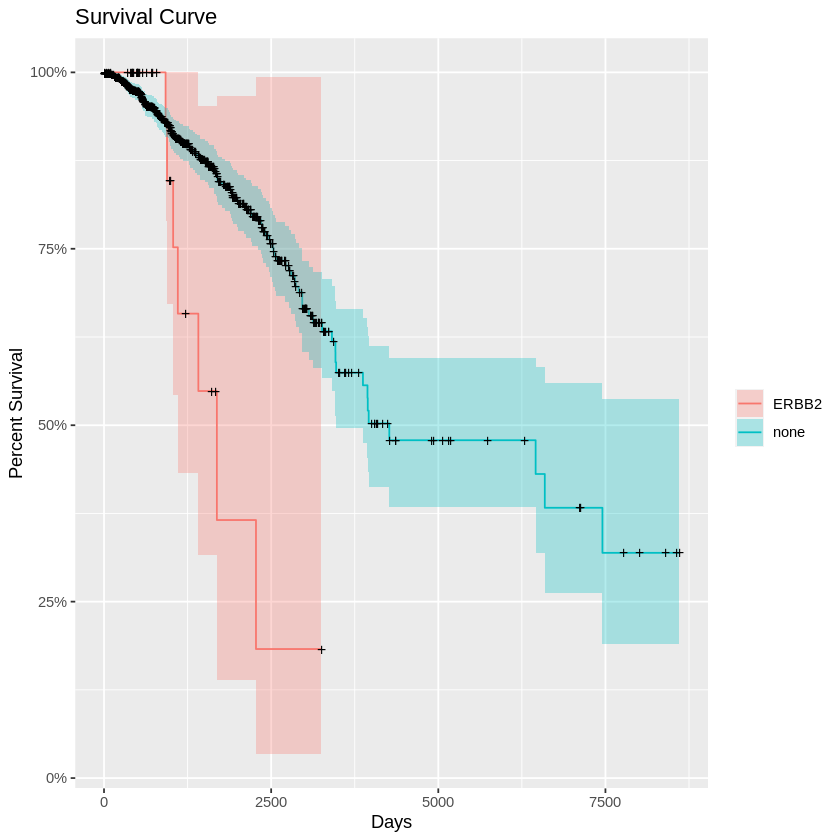

In [79]:
# create a survival curve plot
autoplot(survfit(Surv(days_to_event, vital_status) ~ gene_status, data = survival)) +
  labs(title = "Survival Curve",
       y = "Percent Survival", 
       x = "Days") +
  theme(legend.title=element_blank())

In [80]:
# Analyze the differences between groups with a Log-Rank Test
survdiff(Surv(days_to_event, vital_status) ~ gene_status, data = survival)

Call:
survdiff(formula = Surv(days_to_event, vital_status) ~ gene_status, 
    data = survival)

                    N Observed Expected (O-E)^2/E (O-E)^2/V
gene_status=ERBB2  34        7     2.51     8.064      8.28
gene_status=none  932      125   129.49     0.156      8.28

 Chisq= 8.3  on 1 degrees of freedom, p= 0.004 

## Conclusion

The log rank test in `survdiff` indicates that there is a significant difference between the curves and that there is a difference in outcome based on the mutation of the ERBB2 gene.

## Litature on ERBB2 and Breast Cancer

Kurozumi, S., Alsaleem, M., Monteiro, C.J. et al. Targetable ERBB2 mutation status is an independent marker of adverse prognosis in estrogen receptor positive, ERBB2 non-amplified primary lobular breast carcinoma: a retrospective in silico analysis of public datasets. Breast Cancer Res 22, 85 (2020). https://doi.org/10.1186/s13058-020-01324-4


# Follow Up Questions for Later

We have seen that the ERBB2 gene has an effect on the survival outcome of a patient but do other common genes in Breast Cancer have a similar effect?

- Does a mutation in the gene BRCA1 have an effect on survival outcomes?
- How about BRCA2?

Does mutations in ERBB2 gene have an effect on the survival outcome for other cancers besides Breast Cancer?
- Does a mutation in ERBB2 have an effect on survival outcomes in Ovarian Cancer?

# Contact US
Please contact us to learn more about BigQuery, to discuss cost considerations when working with BigQuery projects, or to discuss any projects you feel may benefit from the ISB-CGC Platform.

* Email us: feedback@isb-cgc.org
* Check out our website: https://isb-cgc.org
* Visit our [office hours](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/office_hours.html)